In [75]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
 
import os
import pandas as pd
import numpy as np
a = [name for name in os.listdir(".") if os.path.isdir(name)]
d = pd.DataFrame()
for i in a:
    if i != '.git' or i!= 'Test':
        b = os.listdir(i)
        b = np.array(b)
        c = pd.DataFrame(b, columns=['filename'])
        c['Class'] = i
        #append to the master dataframe
        d = d.append(c)

from pathlib import Path


df = d
df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = df['Class'] + '/' + df['filename'].astype(str)
df = df.sample(frac=1)
label_encoder = preprocessing.LabelEncoder()

df['classID'] = label_encoder.fit_transform(df['Class'])

# Take relevant columns
df = df[['relative_path', 'classID','Class']]
df.head()
df.to_csv('train.csv', index=False)



In [76]:
df

,relative_path,classID,Class
613,Whimper/4GOAAgtUxzc_30.wav,15,Whimper
427,Snicker/I8OEau20VUw_30.wav,11,Snicker
53,Singing/-0rXXv6jMQ0_30.wav,10,Singing
430,Singing/-BvnQkemiyY_1.wav,10,Singing
292,Whimper/1rqicm2rXR0_27.wav,15,Whimper
...,...,...,...
234,Snicker/9wpBmR-qS84_30.wav,11,Snicker
27,Snicker/0Nd8NBZVOCw_70.wav,11,Snicker
447,Whimper/32tzR69LJNE_11.wav,15,Whimper
415,Singing/-BKQpLL_GLA_30.wav,10,Singing


In [77]:
df.Class.unique()

array(['Whimper', 'Snicker', 'Singing', 'Whoop', 'Screaming',
       'Children shouting', 'Finger snapping', 'Speech', 'Battle cry',
       'Whispering', 'Breathing', 'Clapping', 'Groan', 'Babbling', 'Yell',
       'Bellow', 'shatter', 'Wail, moan', 'Test', '.git'], dtype=object)

In [78]:
df.shape

(6250, 3)

In [79]:
df= df[df['Class'] != 'Test']

In [80]:
df.shape

(6248, 3)

In [81]:
df= df[df['Class'] != '.git']

In [82]:
df.shape

(6235, 3)

In [83]:
#### Dependencies ####
#### Import Comet for experiment tracking and visual tools
from comet_ml import Experiment
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import tensorflow as tf
# from keras.optimizers import Adam
# from keras.utils import to_categorical

In [84]:
experiment = Experiment(
    api_key="TpJmHUzqkFIYdblKq8rPA9vKW",
    project_name="fyp-audio-processing",
    workspace="shakthi-stack",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/shakthi-stack/fyp-audio-processing/9824c5f487184d82bcb7026262150189
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [100]                : (0.1444328874349594, 0.4761706590652466)
COMET INFO:     auc [100]                     : (0.5936114192008972, 0.9126808047294617)
COMET INFO:     batch_accuracy [1600]         : (0.09375, 0.65625)
COMET INFO:     batch_auc [1600]              : (0.52288818359375, 0.96624755859375)
COMET INFO:     batch_loss [1600]             : (1.1141836643218994, 70.193458557128

In [85]:
labels = list(df['classID'].unique())

In [86]:
files = dict()
for i in range(len(labels)):
    tmp = df[df['classID'] == labels[i]][:1].reset_index()
    path = df['relative_path']
    files[labels[i]] = path

In [87]:
fn = 'Snicker/6xfMfFenKiM_70.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 16000
Librosa sample rate: 22050


In [88]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -5272 to 4727
Librosa audio file min~max range: -0.16 to -0.16


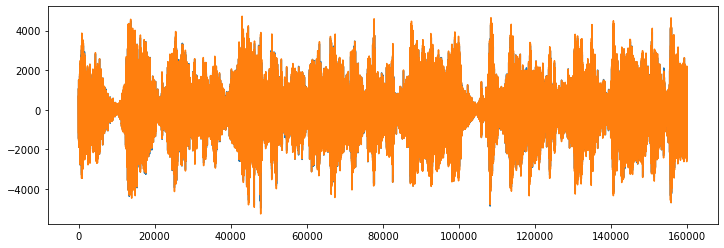

In [89]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

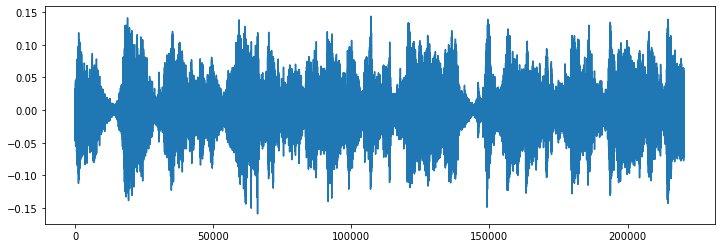

In [90]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)

In [91]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 500)

In [92]:
print(mfccs.shape)

(128, 431)


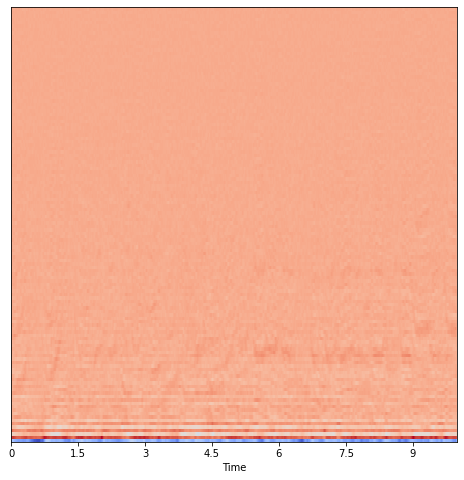

In [93]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [94]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=100)
    mfccs_processed = np.mean(mfccs.T,axis=0) 
    return mfccs_processed

In [95]:
features = []
# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    file_name = row['relative_path']
    # os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"])) 
    class_label = row["Class"]
    try:
        data = extract_features(file_name)
        features.append([data, class_label])
    except:
        print("error")
        continue
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

error


In [96]:
featuresdf

,feature,class_label
0,"[-605.0586, 30.840565, -6.255364, 10.899939, -...",Whimper
1,"[-178.7416, 140.12424, -29.909569, 44.035778, ...",Snicker
2,"[-69.40409, 150.99274, -95.9823, 18.475878, -5...",Singing
3,"[-270.24707, 71.09342, -70.87468, 33.361816, -...",Singing
4,"[-175.48373, 170.3048, -48.98037, -14.934187, ...",Whimper
...,...,...
6229,"[-142.04286, 151.1784, -75.9538, 26.625698, -2...",Snicker
6230,"[-180.96419, 130.81981, -60.414024, 31.285072,...",Snicker
6231,"[-301.72998, 221.67899, -120.52777, 39.402622,...",Whimper
6232,"[-126.83826, 116.50745, -94.467064, 56.329803,...",Singing


In [97]:
featuresdf.iloc[0]['feature']

array([-6.05058594e+02,  3.08405647e+01, -6.25536394e+00,  1.08999386e+01,
       -4.34855413e+00,  5.91892815e+00,  1.57630682e+00,  2.91935658e+00,
        7.60435224e-01, -2.72843838e+00,  4.95274305e-01, -2.90775847e+00,
        1.70735300e+00, -1.15570033e+00, -1.35242498e+00, -2.97504544e+00,
       -2.91155267e+00,  8.93209651e-02, -8.52023363e-01,  6.48372322e-02,
       -1.57881057e+00, -7.10168123e-01, -1.41000569e+00, -6.16708219e-01,
        4.00314964e-02, -9.48228300e-01, -2.62767762e-01, -5.39125502e-01,
        3.91680002e-03, -8.20307672e-01, -4.75346744e-01, -3.84747148e-01,
       -6.61633849e-01, -9.74156380e-01, -9.81468976e-01, -1.80975631e-01,
       -5.85106850e-01, -3.96096855e-01, -7.92449236e-01, -7.46273518e-01,
       -7.84237325e-01, -4.41648245e-01,  1.13585358e-02, -4.97612625e-01,
       -7.98486888e-01, -7.80630529e-01,  1.07218131e-01, -7.76693076e-02,
       -1.11202106e-01, -2.29023561e-01, -3.64677221e-01, -2.48943359e-01,
       -5.40360630e-01, -

In [126]:
from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [127]:
X.shape

(6234, 100)

In [128]:
y

array(['Whimper', 'Snicker', 'Singing', ..., 'Whimper', 'Singing',
       'Whoop'], dtype='<U17')

In [142]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [143]:
num_labels = yy.shape[1]
filter_size = 2
def build_model_graph(input_shape=(100,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy','AUC'], optimizer='adam')
    return model
model = build_model_graph()

In [144]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
156/156 [==============================] - 1s 6ms/step - loss: 10.5145 - accuracy: 0.1506 - auc: 0.6074 - val_loss: 2.8031 - val_accuracy: 0.2478 - val_auc: 0.6999
Epoch 2/100
156/156 [==============================] - 1s 4ms/step - loss: 2.9909 - accuracy: 0.1817 - auc: 0.6665 - val_loss: 2.6829 - val_accuracy: 0.2494 - val_auc: 0.7634
Epoch 3/100
156/156 [==============================] - 1s 4ms/step - loss: 2.6718 - accuracy: 0.2244 - auc: 0.7253 - val_loss: 2.4388 - val_accuracy: 0.2823 - val_auc: 0.7989
Epoch 4/100
156/156 [==============================] - 1s 4ms/step - loss: 2.5609 - accuracy: 0.2507 - auc: 0.7526 - val_loss: 2.3411 - val_accuracy: 0.2871 - val_auc: 0.8145
Epoch 5/100
156/156 [==============================] - 1s 4ms/step - loss: 2.4532 - accuracy: 0.2559 - auc: 0.7767 - val_loss: 2.2727 - val_accuracy: 0.2951 - val_auc: 0.8227
Epoch 6/100
156/156 [==============================] - 1s 4ms/step - loss: 2.4201 - accuracy: 0.2669 - auc: 0.7867 - val_los

In [146]:
output = model.predict(x_test)

In [147]:
output[1]

array([1.0981948e-05, 2.7601564e-02, 7.2670944e-02, 3.4602090e-05,
       9.1725916e-02, 3.7221979e-02, 1.6950093e-10, 1.2075441e-02,
       4.6891488e-02, 8.6045608e-02, 1.4972601e-02, 5.0981697e-02,
       1.5282928e-04, 6.1776832e-02, 1.9660122e-03, 2.9576764e-01,
       1.9668312e-01, 3.4207467e-03], dtype=float32)

In [148]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 53.56%
Testing Accuracy: 39.13%


In [108]:
fn = 'Test/dv_test_1-[AudioTrimmer.com].wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


In [89]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -10497 to 10629
Librosa audio file min~max range: -0.25 to -0.25


In [109]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 100)

In [110]:
mfccs.shape

(100, 3116)

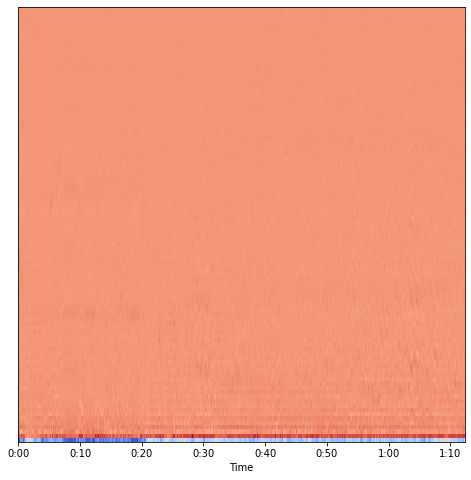

In [111]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [112]:
mfccs_processed = np.mean(mfccs.T,axis=0)

In [113]:
mfccs_processed

array([-3.5428116e+02,  1.0043304e+02,  3.7815650e+00,  2.6591024e+01,
        6.7473307e+00,  1.4398628e+01, -1.6803311e+00,  7.8047161e+00,
        4.6000943e-01,  4.8551879e+00, -1.0996917e-01,  5.8239813e+00,
        3.5230878e-01,  4.6289320e+00,  3.9206704e-01,  3.4700875e+00,
        9.3890035e-01,  3.1523869e+00, -6.1137092e-01,  1.5630028e+00,
       -4.3711066e-01,  2.2856452e+00, -7.5055462e-01, -2.0804171e-01,
       -2.1168647e+00,  5.1132917e-01, -1.8325610e+00,  6.3369405e-01,
       -9.0112585e-01,  1.1527293e+00, -5.2314895e-01,  1.4939402e+00,
       -3.3133012e-01,  6.8298340e-01, -1.4745341e-01,  1.3305136e+00,
       -9.0843037e-02,  8.3173327e-03, -2.0241816e+00, -1.1658217e+00,
       -1.1992157e+00,  3.3290023e-01, -1.6634411e+00, -1.0936072e+00,
       -1.7619939e+00, -2.2057742e-01, -1.0082159e+00, -3.4676087e-01,
       -1.8426174e+00, -1.3083518e+00, -1.9708797e+00, -1.0640537e+00,
       -2.0740361e+00, -1.6954092e+00, -2.3442700e+00, -9.5806080e-01,
      

In [114]:
X = np.array(mfccs_processed.tolist())

In [115]:
X.shape

(100,)

In [116]:
X

array([-3.54281158e+02,  1.00433037e+02,  3.78156495e+00,  2.65910244e+01,
        6.74733067e+00,  1.43986282e+01, -1.68033111e+00,  7.80471611e+00,
        4.60009426e-01,  4.85518789e+00, -1.09969169e-01,  5.82398129e+00,
        3.52308780e-01,  4.62893200e+00,  3.92067045e-01,  3.47008753e+00,
        9.38900352e-01,  3.15238690e+00, -6.11370921e-01,  1.56300282e+00,
       -4.37110662e-01,  2.28564525e+00, -7.50554621e-01, -2.08041713e-01,
       -2.11686468e+00,  5.11329174e-01, -1.83256102e+00,  6.33694053e-01,
       -9.01125848e-01,  1.15272927e+00, -5.23148954e-01,  1.49394023e+00,
       -3.31330121e-01,  6.82983398e-01, -1.47453412e-01,  1.33051360e+00,
       -9.08430368e-02,  8.31733271e-03, -2.02418160e+00, -1.16582167e+00,
       -1.19921565e+00,  3.32900226e-01, -1.66344106e+00, -1.09360719e+00,
       -1.76199389e+00, -2.20577419e-01, -1.00821590e+00, -3.46760869e-01,
       -1.84261739e+00, -1.30835176e+00, -1.97087967e+00, -1.06405365e+00,
       -2.07403612e+00, -

In [117]:
x=np.reshape(X,(-1,100))

In [118]:
x.shape

(1, 100)

In [119]:
x

array([[-3.54281158e+02,  1.00433037e+02,  3.78156495e+00,
         2.65910244e+01,  6.74733067e+00,  1.43986282e+01,
        -1.68033111e+00,  7.80471611e+00,  4.60009426e-01,
         4.85518789e+00, -1.09969169e-01,  5.82398129e+00,
         3.52308780e-01,  4.62893200e+00,  3.92067045e-01,
         3.47008753e+00,  9.38900352e-01,  3.15238690e+00,
        -6.11370921e-01,  1.56300282e+00, -4.37110662e-01,
         2.28564525e+00, -7.50554621e-01, -2.08041713e-01,
        -2.11686468e+00,  5.11329174e-01, -1.83256102e+00,
         6.33694053e-01, -9.01125848e-01,  1.15272927e+00,
        -5.23148954e-01,  1.49394023e+00, -3.31330121e-01,
         6.82983398e-01, -1.47453412e-01,  1.33051360e+00,
        -9.08430368e-02,  8.31733271e-03, -2.02418160e+00,
        -1.16582167e+00, -1.19921565e+00,  3.32900226e-01,
        -1.66344106e+00, -1.09360719e+00, -1.76199389e+00,
        -2.20577419e-01, -1.00821590e+00, -3.46760869e-01,
        -1.84261739e+00, -1.30835176e+00, -1.97087967e+0

In [120]:
output = model.predict(x)

In [121]:
output

array([[7.3928602e-02, 6.9277775e-07, 6.4408447e-04, 8.7902375e-02,
        2.1200310e-06, 2.4383382e-03, 1.0438096e-02, 3.8317665e-02,
        4.6141869e-03, 7.7816802e-03, 2.4856098e-02, 1.3932176e-01,
        3.5016716e-03, 2.6610425e-01, 3.0657014e-01, 9.3888404e-04,
        1.7814789e-05, 3.2621600e-02]], dtype=float32)

In [122]:
output.max()

0.30657014

In [123]:
output.sort()

In [124]:
output

array([[6.9277775e-07, 2.1200310e-06, 1.7814789e-05, 6.4408447e-04,
        9.3888404e-04, 2.4383382e-03, 3.5016716e-03, 4.6141869e-03,
        7.7816802e-03, 1.0438096e-02, 2.4856098e-02, 3.2621600e-02,
        3.8317665e-02, 7.3928602e-02, 8.7902375e-02, 1.3932176e-01,
        2.6610425e-01, 3.0657014e-01]], dtype=float32)

In [64]:
fn = 'Test/test_2-[AudioTrimmer.com].wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


In [65]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 100)

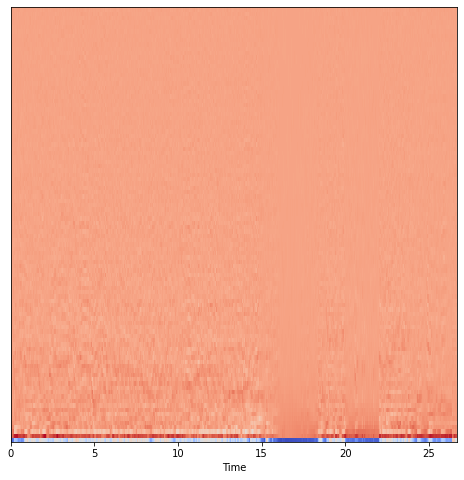

In [66]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [67]:
mfccs_processed = np.mean(mfccs.T,axis=0)

In [68]:
X = np.array(mfccs_processed.tolist())
x=np.reshape(X,(-1,100))

In [69]:
output = model.predict(x)

In [70]:
output

array([[5.5899702e-02, 4.4649115e-04, 3.3539096e-03, 4.9688254e-04,
        2.0740010e-02, 4.6636438e-04, 5.2065898e-02, 4.2701453e-02,
        2.1171670e-03, 6.3462667e-02, 6.3738368e-02, 1.4681281e-02,
        4.8015007e-01, 1.3136110e-01, 1.5185411e-02, 5.9034801e-03,
        4.7229651e-02]], dtype=float32)

In [71]:
output.max()

0.48015007

In [72]:
output.sort()

In [74]:
output

array([[4.4649115e-04, 4.6636438e-04, 4.9688254e-04, 2.1171670e-03,
        3.3539096e-03, 5.9034801e-03, 1.4681281e-02, 1.5185411e-02,
        2.0740010e-02, 4.2701453e-02, 4.7229651e-02, 5.2065898e-02,
        5.5899702e-02, 6.3462667e-02, 6.3738368e-02, 1.3136110e-01,
        4.8015007e-01]], dtype=float32)